# Baseline Model - Multinomial Logit (MNL)

## Importing Packages and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
np.random.seed(100)

In [3]:
DF = pd.read_csv('data_for_ml.csv')
DF.head(2)

,INDEX_,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,VEH_ADT,PED_ADT,LAND_USE,POP_2021,PRIV_DWELL,LAND_AREA,INVAGE,PEDCOND,PEDACT,VEHINV,VIOL,INJURY
0,3366652,7,weekday,Other,Dark,Wet,1.5,0.99,Midblock,No Control,Major Arterial,60,498.0,219.0,Mixed Use,504,263,225,45 to 64,Distracted,Crossing without ROW,automobile,speeding,Major
1,3370334,19,weekday,Rain,Dark,Wet,4.8,1.00,Midblock,Traffic Signal including Transit,Major Arterial,60,351.0,63.0,Residential,452,205,183,Over 65,Normal,Crossing without ROW,automobile,speeding,Major


In [4]:
df = DF.drop('INDEX_',axis=1)
df.head(1)

,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,VEH_ADT,PED_ADT,LAND_USE,POP_2021,PRIV_DWELL,LAND_AREA,INVAGE,PEDCOND,PEDACT,VEHINV,VIOL,INJURY
0,7,weekday,Other,Dark,Wet,1.5,0.99,Midblock,No Control,Major Arterial,60,498.0,219.0,Mixed Use,504,263,225,45 to 64,Distracted,Crossing without ROW,automobile,speeding,Major


In [5]:
# Integer encode the INJURY column
injury_map = {
    'Fatal' : 4,
    'Major' : 3,
    'Minor' : 2,
    'Minimal' : 1,
    np.nan : 0
}
df['INJURY'] = df['INJURY'].replace(injury_map).astype(int)
df.head(1)

,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,VEH_ADT,PED_ADT,LAND_USE,POP_2021,PRIV_DWELL,LAND_AREA,INVAGE,PEDCOND,PEDACT,VEHINV,VIOL,INJURY
0,7,weekday,Other,Dark,Wet,1.5,0.99,Midblock,No Control,Major Arterial,60,498.0,219.0,Mixed Use,504,263,225,45 to 64,Distracted,Crossing without ROW,automobile,speeding,3


# Data Preprocessing for ML

In [6]:
# Split into X and y variables
X = df.iloc[:, :-1].values
y = df.iloc[:,-1].values

In [7]:
# One hot encode the categorical columns
cat_columns_index = [1, 2, 3, 4, 7, 8, 9, 13, 17, 18, 19, 20, 21]
encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(X[:, cat_columns_index])

In [8]:
# Combine the categorical and numerical columns
num_columns_index = [0, 5, 6, 10, 11, 12, 14, 15, 16]
X_encoded = np.concatenate((X_cat, X[:, num_columns_index]), axis=1)
print(X_encoded)

[[1.0 0.0 0.0 ... 504 263 225]
 [1.0 0.0 0.0 ... 452 205 183]
 [1.0 0.0 1.0 ... 807 375 322]
 ...
 [1.0 0.0 0.0 ... 482 252 231]
 [0.0 1.0 1.0 ... 1981 1195 1112]
 [1.0 0.0 1.0 ... 1170 482 467]]


In [9]:
# Split encoded X and y to train test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.20, random_state=100)

In [10]:
# Scale the numerical features
scaler = StandardScaler()
X_train[:, -len(num_columns_index):] = scaler.fit_transform(X_train[:, -len(num_columns_index):])
X_test[:, -len(num_columns_index):] = scaler.transform(X_test[:, -len(num_columns_index):])
print(X_train)
print(X_test)

[[1.0 0.0 1.0 ... -0.5867732574402085 -0.5265834440260664
  -0.5226000650737648]
 [1.0 0.0 1.0 ... 2.0284752641268318 1.433142186594836 1.5585892351770785]
 [1.0 0.0 1.0 ... 1.7854821802357512 2.0608224248081974
  2.0504771899165526]
 ...
 [1.0 0.0 0.0 ... -0.6056832250581914 -0.4655195294487484
  -0.4803918577363841]
 [1.0 0.0 0.0 ... -0.32297920916934647 -0.45841907426533934
  -0.4511707911181976]
 [0.0 1.0 1.0 ... -0.44400300192443726 -0.049432855700977114
  -0.03395889551408934]]
[[1.0 0.0 1.0 ... -0.6151382088671828 -0.5336838992094755
  -0.5339638132030595]
 [0.0 1.0 1.0 ... -0.7739819368582396 -0.6714327297676114
  -0.6833159314737909]
 [1.0 0.0 1.0 ... -0.37781811526149695 -0.3717935210277487
  -0.36350759126363785]
 ...
 [1.0 0.0 1.0 ... -0.27570429012438913 0.1025168852239769
  0.03260020067178006]
 [0.0 1.0 1.0 ... -0.6208111991525778 -0.4413779818251576
  -0.4609111466575931]
 [1.0 0.0 1.0 ... -0.7248160210514839 -0.5919076317134297
  -0.6005229093889289]]


# Modeling

In [11]:
# Parameter Grid
param_grid = {
    'solver' : ['lbfgs', 'newton-cg', 'saga'],
    'penalty': ['l2', 'l1', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'multi_class': ['ovr', 'multinomial']
}

In [12]:
# Hyperparameter Tuning
logreg = LogisticRegression()

logreg_rs = RandomizedSearchCV(estimator=logreg,
                                param_distributions=param_grid,
                                n_iter = 100,
                                cv = 5,
                                scoring = 'accuracy',
                                random_state=100)

In [13]:
logreg_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'multi_class': ['ovr', 'multinomial'],
                                        'penalty': ['l2', 'l1', 'elasticnet',
                                                    'none'],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'saga']},
                   random_state=100, scoring='accuracy')

## Model Performance

Training Accuracy: 78.23%
Test Accuracy: 76.57%
Precision: 67.30%
Recall: 76.57%
F1 Score: 70.81%

Confusion Matrix:
[[  0   0   0   6   0]
 [  0   0   0  14   0]
 [  0   0   0  17   3]
 [  0   0   0 464  24]
 [  0   0   0  82  13]]



<Axes: >

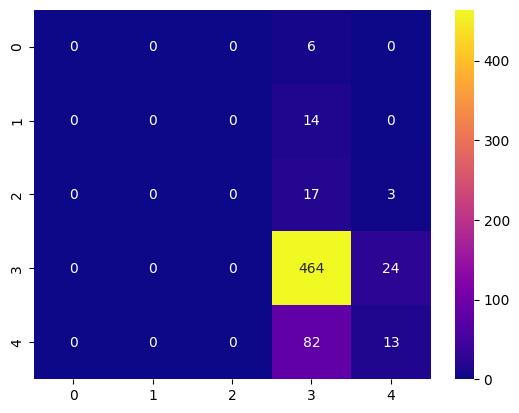

In [14]:
y_pred = logreg_rs.predict(X_test)
# Training and Testing Accuracy Score
print(f"Training Accuracy: {logreg_rs.best_score_*100:.2f}%")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
# Other Metrics
print(f"Precision: {precision_score(y_test, y_pred, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')*100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')*100:.2f}%\n")
# Confusion Matrix
print(f"Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"{cm}\n")
sns.heatmap(cm, annot=True, fmt='g', cmap='plasma')

In [15]:
# Best Parameters
logreg_rs.best_params_

{'solver': 'saga', 'penalty': 'none', 'multi_class': 'ovr', 'C': 0.001}

# Binary Outcome Predictions

In [19]:
alt_df = pd.read_csv('data_for_ml.csv')
alt_df = alt_df.drop('INDEX_',axis=1)
# Binary integer encode, 1 as fatal and 0 as non-fatal
injury_binary = {
    'Fatal' : 1,
    'Major' : 0,
    'Minor' : 0,
    'Minimal' : 0,
    np.nan : 0
}
# Replace
alt_df['INJURY'] = alt_df['INJURY'].replace(injury_binary).astype(int)
alt_df.head(1)

,HOUR,DAYOFWEEK,VISIBILITY,LIGHT,RDSFCOND,TEMP,REL_HUMID,LOCCOORD,TRAFFCTL,ROADCLASS,SPEEDLMT,VEH_ADT,PED_ADT,LAND_USE,POP_2021,PRIV_DWELL,LAND_AREA,INVAGE,PEDCOND,PEDACT,VEHINV,VIOL,INJURY
0,7,weekday,Other,Dark,Wet,1.5,0.99,Midblock,No Control,Major Arterial,60,498.0,219.0,Mixed Use,504,263,225,45 to 64,Distracted,Crossing without ROW,automobile,speeding,0


## Preprocessing

In [20]:
# Split into X and y variables
X = alt_df.iloc[:, :-1].values
y = alt_df.iloc[:,-1].values

# One hot encode the categorical columns
cat_columns_index = [1, 2, 3, 4, 7, 8, 9, 13, 17, 18, 19, 20, 21]
encoder = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(X[:, cat_columns_index])

# Combine the categorical and numerical columns
num_columns_index = [0, 5, 6, 10, 11, 12, 14, 15, 16]
X_encoded = np.concatenate((X_cat, X[:, num_columns_index]), axis=1)

# Split encoded X and y to train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_encoded, y, test_size=0.20, random_state=100)

# Scale the numerical features
scaler = StandardScaler()
X_train2[:, -len(num_columns_index):] = scaler.fit_transform(X_train2[:, -len(num_columns_index):])
X_test2[:, -len(num_columns_index):] = scaler.transform(X_test2[:, -len(num_columns_index):])
print(f"Explanatory Variable Train Set Dimension: {X_train2.shape}")
print(f"Explanatory Variable Test Set Dimension: {X_test2.shape}")

Explanatory Variable Train Set Dimension: (2490, 83)
Explanatory Variable Test Set Dimension: (623, 83)


## Modeling

In [21]:
# Parameter Grid
param_grid_binary = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Hyperparameter Tuning
logreg_binary = LogisticRegression()

logreg_rs_binary = RandomizedSearchCV(estimator=logreg_binary,
                                param_distributions=param_grid_binary,
                                n_iter = 100,
                                cv = 5,
                                scoring = 'accuracy',
                                random_state=100)

# Fit the model
logreg_rs_binary.fit(X_train2, y_train2)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=100, scoring='accuracy')

Training Accuracy: 84.18%
Test Accuracy: 82.83%
Precision: 78.09%
Recall: 82.83%
F1 Score: 79.58%

Confusion Matrix:
[[503  25]
 [ 82  13]]



Text(50.722222222222214, 0.5, 'Actual Label')

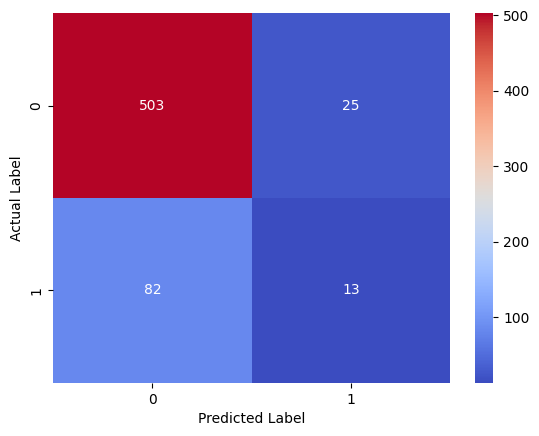

In [24]:
# Performance metrics
y_pred2 = logreg_rs_binary.predict(X_test2)
# Training and Testing Accuracy Score
print(f"Training Accuracy: {logreg_rs_binary.best_score_*100:.2f}%")
print(f"Test Accuracy: {accuracy_score(y_test2, y_pred2)*100:.2f}%")
# Other Metrics
print(f"Precision: {precision_score(y_test2, y_pred2, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_test2, y_pred2, average='weighted')*100:.2f}%")
print(f"F1 Score: {f1_score(y_test2, y_pred2, average='weighted')*100:.2f}%\n")
# Confusion Matrix
print(f"Confusion Matrix:")
cm = confusion_matrix(y_test2, y_pred2)
print(f"{cm}\n")
sns.heatmap(cm, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')